In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D


In [2]:
dataset_path = r"E:\Lung_Cancer_Detection-main\The IQ-OTHNCCD lung cancer dataset"
raw_train = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(224,224),
    batch_size=16
)

raw_test = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(224,224),
    batch_size=16
)

# save class names
CLASS_NAMES = raw_train.class_names
print("Classes:", CLASS_NAMES)



Found 1097 files belonging to 3 classes.
Using 878 files for training.
Found 1097 files belonging to 3 classes.
Using 219 files for validation.
Classes: ['Bengin cases', 'Malignant cases', 'Normal cases']


In [3]:
def pdf_preprocess(image, label):
    # RGB → Grayscale
    image = tf.image.rgb_to_grayscale(image)

    # Convert to float32
    image = tf.cast(image, tf.float32)

    # Normalize
    image = image / 255.0

    # Noise reduction (Gaussian-like)
    image = tf.nn.avg_pool2d(
        image,
        ksize=3,
        strides=1,
        padding="SAME"
    )

    # Contrast enhancement (CLAHE approximation)
    image = tf.image.adjust_contrast(image, contrast_factor=2.0)

    # Back to 3 channels
    image = tf.image.grayscale_to_rgb(image)

    return image, label


In [4]:
train_data = (
    raw_train
    .map(pdf_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

test_data = (
    raw_test
    .map(pdf_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)


In [5]:
def plot_history(history, model_name):
    acc = history.history.get("accuracy")
    val_acc = history.history.get("val_accuracy")
    loss = history.history.get("loss")
    val_loss = history.history.get("val_loss")

    plt.figure(figsize=(12, 5))

    # ACCURACY
    plt.subplot(1, 2, 1)
    if acc is not None:
        plt.plot(acc, label="Train Accuracy")
    if val_acc is not None:
        plt.plot(val_acc, label="Val Accuracy")
    plt.title(f"{model_name} Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # LOSS
    plt.subplot(1, 2, 2)
    if loss is not None:
        plt.plot(loss, label="Train Loss")
    if val_loss is not None:
        plt.plot(val_loss, label="Val Loss")
    plt.title(f"{model_name} Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()


In [6]:
def evaluate(model, model_name):
    class_names = CLASS_NAMES

    # TRUE LABELS (use raw_test, not prefetched dataset)
    y_true = np.concatenate([y.numpy() for x, y in raw_test], axis=0)
    y_true = np.argmax(y_true, axis=1)

    # PREDICTIONS
    y_pred = np.concatenate([model.predict(x) for x, y in raw_test], axis=0)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # CONFUSION MATRIX
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(model_name + " Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # CLASSIFICATION REPORT
    print(classification_report(y_true, y_pred_classes, target_names=class_names))


Epoch 1/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 46s 763ms/step - accuracy: 0.4601 - loss: 1.1458 - val_accuracy: 0.6895 - val_loss: 0.8443
Epoch 2/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 39s 715ms/step - accuracy: 0.5501 - loss: 0.9689 - val_accuracy: 0.6986 - val_loss: 0.8013
Epoch 3/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 40s 723ms/step - accuracy: 0.5809 - loss: 0.9035 - val_accuracy: 0.7123 - val_loss: 0.7714
Epoch 4/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 39s 714ms/step - accuracy: 0.6185 - loss: 0.8396 - val_accuracy: 0.7078 - val_loss: 0.7494
Epoch 5/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 39s 707ms/step - accuracy: 0.6469 - loss: 0.7757 - val_accuracy: 0.7397 - val_loss: 0.7283


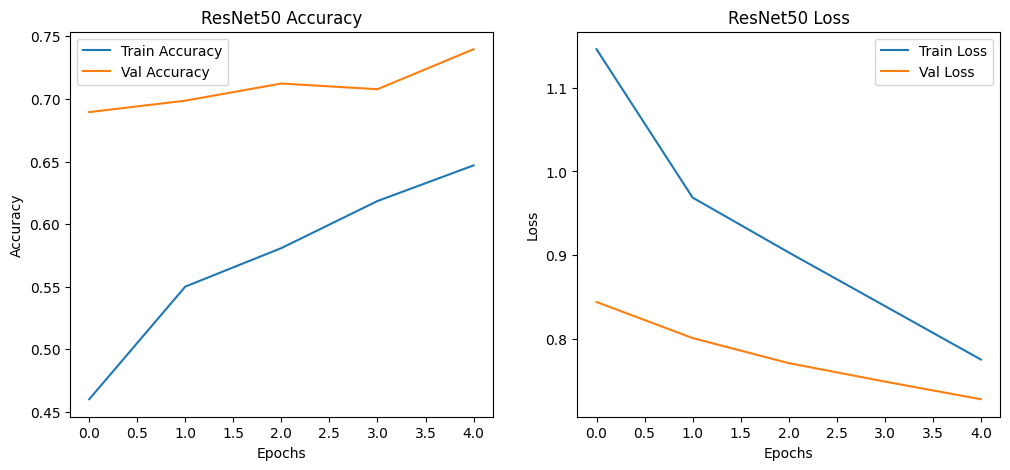

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


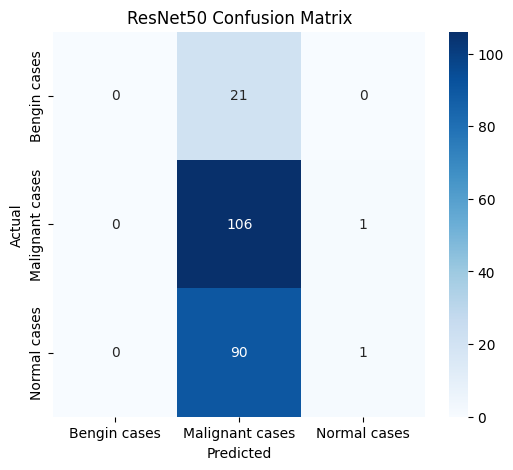

                 precision    recall  f1-score   support

   Bengin cases       0.00      0.00      0.00        21
Malignant cases       0.49      0.99      0.65       107
   Normal cases       0.50      0.01      0.02        91

       accuracy                           0.49       219
      macro avg       0.33      0.33      0.23       219
   weighted avg       0.45      0.49      0.33       219



c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

In [7]:
from tensorflow.keras.applications import ResNet50

base = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))

for layer in base.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(3, activation="softmax")(x)

resnet_model = Model(inputs=base.input, outputs=output)
resnet_model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

history_resnet = resnet_model.fit(train_data, validation_data=test_data, epochs=5)

resnet_model.save("ResNet50.keras")
plot_history(history_resnet, "ResNet50")

# CORRECT CALL:
evaluate(resnet_model, "ResNet50")



Epoch 1/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7210 - loss: 0.6751 - val_accuracy: 0.8447 - val_loss: 0.4160
Epoch 2/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.8781 - loss: 0.3170 - val_accuracy: 0.8858 - val_loss: 0.2854
Epoch 3/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9055 - loss: 0.2479 - val_accuracy: 0.8950 - val_loss: 0.2312
Epoch 4/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9419 - loss: 0.1795 - val_accuracy: 0.9178 - val_loss: 0.1943
Epoch 5/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9590 - loss: 0.1264 - val_accuracy: 0.9452 - val_loss: 0.1536


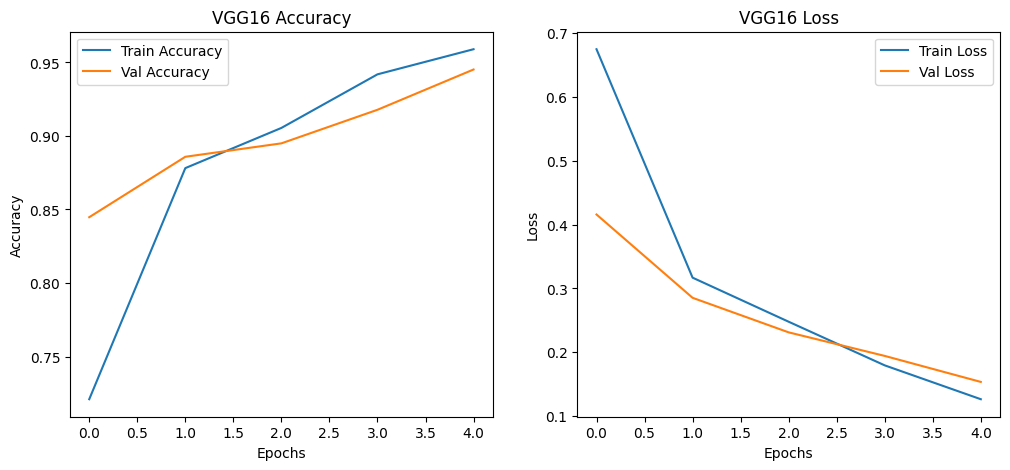

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step


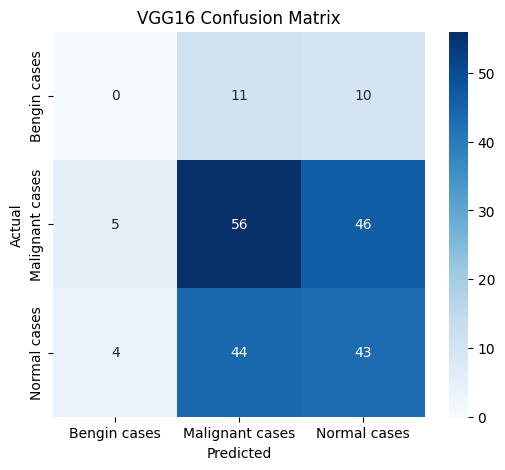

                 precision    recall  f1-score   support

   Bengin cases       0.00      0.00      0.00        21
Malignant cases       0.50      0.52      0.51       107
   Normal cases       0.43      0.47      0.45        91

       accuracy                           0.45       219
      macro avg       0.31      0.33      0.32       219
   weighted avg       0.43      0.45      0.44       219



In [8]:
from tensorflow.keras.applications import VGG16

base = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))

for layer in base.layers:
    layer.trainable = False

x = Flatten()(base.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(3, activation="softmax")(x)

vgg_model = Model(inputs=base.input, outputs=output)
vgg_model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

history_vgg = vgg_model.fit(train_data, validation_data=test_data, epochs=5)

vgg_model.save("VGG16.keras")
plot_history(history_vgg, "VGG16")
evaluate(vgg_model, "VGG16")


Epoch 1/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 27s 405ms/step - accuracy: 0.6139 - loss: 0.9181 - val_accuracy: 0.7763 - val_loss: 0.5911
Epoch 2/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 362ms/step - accuracy: 0.7654 - loss: 0.5933 - val_accuracy: 0.8265 - val_loss: 0.4831
Epoch 3/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step - accuracy: 0.8200 - loss: 0.4827 - val_accuracy: 0.8493 - val_loss: 0.4047
Epoch 4/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.8519 - loss: 0.3889 - val_accuracy: 0.8539 - val_loss: 0.3678
Epoch 5/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 364ms/step - accuracy: 0.8827 - loss: 0.3462 - val_accuracy: 0.8447 - val_loss: 0.3500


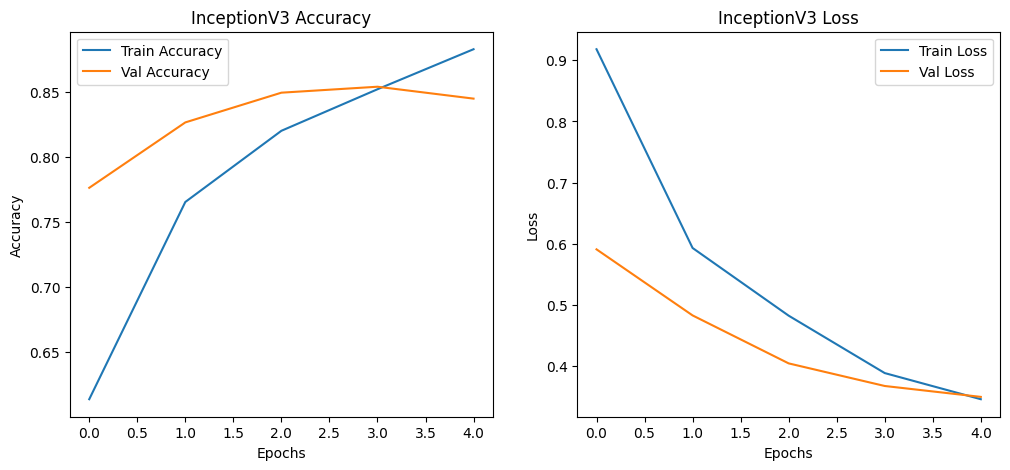

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


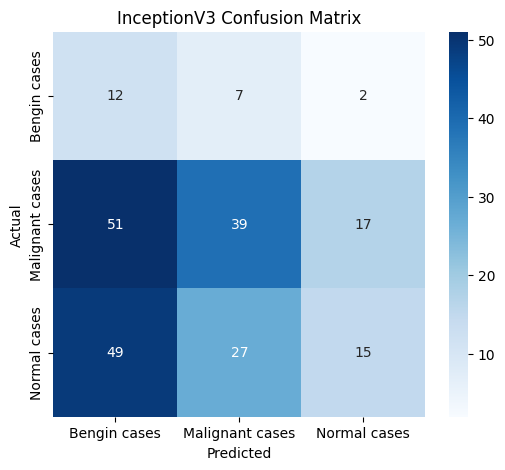

                 precision    recall  f1-score   support

   Bengin cases       0.11      0.57      0.18        21
Malignant cases       0.53      0.36      0.43       107
   Normal cases       0.44      0.16      0.24        91

       accuracy                           0.30       219
      macro avg       0.36      0.37      0.28       219
   weighted avg       0.45      0.30      0.33       219



In [9]:
from tensorflow.keras.applications import InceptionV3

base = InceptionV3(weights="imagenet", include_top=False, input_shape=(224,224,3))

for layer in base.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(3, activation="softmax")(x)

inception_model = Model(inputs=base.input, outputs=output)
inception_model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

history_inception = inception_model.fit(train_data, validation_data=test_data, epochs=5)

inception_model.save("InceptionV3.keras")
plot_history(history_inception, "InceptionV3")
evaluate(inception_model, "InceptionV3")


In [10]:
print("Model Training Complete!\n")
print("Saved Models:\n")
print("✔ ResNet50.keras")
print("✔ VGG16.keras")
print("✔ InceptionV3.keras")


Model Training Complete!

Saved Models:

✔ ResNet50.keras
✔ VGG16.keras
✔ InceptionV3.keras
